# Install Dependencies
This runs a pip install using the requirements.txt file that installs the dependencies for this notebook. Remove the # when first running this notebook on your machine. Afterward you can add it again.


In [1]:
#!pip install -r requirements.txt

# Imports


In [2]:
import numpy as np
import pandas as pd
import psycopg2
from psycopg2 import sql
import os
import requests
from decimal import Decimal
import concurrent.futures
import matplotlib.pyplot as plt
import os.path
import seaborn as sns


# User Settings

- years: An array of year Numbers that we want to download
- stationsFilePath: the path where the stations data is stored and located
- modifiedStationsFilePath: the path where the modified stations data is stored
- downloadCSVFilePath: where the csv.gz files from the ncei file server should be saved
- modifiedCSVFilePath: where the modified csv files should be saved
- dbname: the name of the database you want to connect to
- dbuser: the user that you want to connect with to the database
- dbpassword: the password for the user

In [3]:
years = [1949, 1950]
stationsFilePath = "./data/stations/"
modifiedStationsFilePath = "./data/stations/modifiedStations/"
downloadCSVFilePath = "./data/NCEI/ghcn/daily/"
modifiedCSVFilePath = "./data/NCEI/modified/daily/"
dbname = "NCEIDatabase"
dbuser = "ESDP"
dbpassword = "esdp1"


# Docker Setup

remember to execute the command `docker-compose up --build` if it's the first time running this file (or you changed the dbname, dbuser, dbpassword variables) and `docker-compose up` when have build the docker container previously

In [4]:
#This command writes the dbname, dbuser and dbpassword to an env file which is used by the docker-container during postgresql setup
envVariables = {
    "DATABASE_NAME": dbname,
    "DATABASE_USER": dbuser,
    "DATABASE_PASSWORD": dbpassword,
}

with open(".env", "w") as env_file:
    for key, value in envVariables.items():
        env_file.write(f"{key}={value}\n")

print(".env file created successfully.")

.env file created successfully.


In [5]:
#!docker-compose up -d --build

# Constants

Don't change these unless you know what you are doing
- httpsLink: The https link to the ncei.noaa folder that contains the zipped daily weather data files



In [6]:
#httpsLink = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_year/"
#possible_years = np.arange(1949, 2020, 1)
host = "localhost"
port = "5432"

#this defines the names of the columns in the postgresql database
stationCols = ["id", "latitude", "longitude", "elevation", "state", "name", "gsn_flag", "hcn_crn_flag", "wmo_id"]
weatherCols = ["id", "stationcode", "datelabel", "param", "value", "mflag", "qflag", "sflag", "time"]


# Function Definitions for reusability

In [7]:
## These are the Functions to download the data from the website and convert them
def download_stations(file_path_dest="./data/stations/"):
    """
    This function downloads the stations information (readme and ghcnd-stations.txt file) from the NCEI website and saves it in the specified directory
    
    :param file_path_dest: directory where the stations information will be saved
    :return: 
    """
    url = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"
    response = requests.get(url)
    if response.ok:
        filename = url.rsplit('/', 1)[1]
        print(f"data downloaded. Will be saved as {filename} in {file_path_dest}")
        os.makedirs(file_path_dest, exist_ok=True)
        with open(f"{file_path_dest}{filename}", "wb") as f:
            f.write(response.content)
    else:
        print("An error occured while trying to retrieve the data from the internet.")

    url = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/readme.txt"
    response = requests.get(url)
    if response.ok:
        filename = url.rsplit('/', 1)[1]
        print(f"data downloaded. Will be saved as {filename} in {file_path_dest}")
        os.makedirs(file_path_dest, exist_ok=True)
        with open(f"{file_path_dest}{filename}", "wb") as f:
            f.write(response.content)
    else:
        print("An error occured while trying to retrieve the data from the internet.")

    print("Data downloaded and saved in", file_path_dest)
    return


def convert_stations(file_path="./data/stations/", file_path_dest="./data/modifiedStations/"):
    """
    This converts the ghcnd-stations.txt file to a csv file that we can load into the database
    
    :param file_path: The file path where the original ghcnd-stations.txt file is located
    :param file_path_dest: The path where the modified station file should be saved
    :return: 
    """

    # two helper functions
    def conv_str(x):
        return str(x)

    def conv_float(x):
        return float(x)

    # we get this information from the readme.txt file
    column_specs = [
        (0, 11),  # ID
        (12, 20),  # LATITUDE
        (21, 30),  # LONGITUDE
        (31, 37),  # ELEVATION
        (38, 40),  # STATE
        (41, 71),  # NAME
        (72, 75),  # GSN FLAG
        (76, 79),  # HCN/CRN FLAG
        (80, 85)  # WMO ID
    ]
    column_names = [
        'ID', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'STATE', 'NAME',
        'GSN FLAG', 'HCN/CRN FLAG', 'WMO ID'
    ]

    col_conv = {'ID': conv_str,
                'LATITUDE': conv_float,
                'LONGITUDE': conv_float,
                'ELEVATION': conv_float,
                'STATE': conv_str,
                'NAME': conv_str,
                'GSN FLAG': conv_str,
                'HCN/CRN FLAG': conv_str,
                'WMO ID': conv_str,
                }

    path_to_file = f"{file_path}ghcnd-stations.txt"
    df = pd.read_fwf(path_to_file, colspecs=column_specs, names=column_names, converters=col_conv)
    rename_columns = {
        'ID': 'code',
        'LATITUDE': 'lat',
        'LONGITUDE': 'lon',
        'ELEVATION': 'elevation',
        'STATE': 'state',
        'NAME': 'name',
        'GSN FLAG': 'flag1',
        'HCN/CRN FLAG': 'flag2',
        'WMO ID': 'wmo_id'
    }

    df.rename(columns=rename_columns, inplace=True)

    df['wmo_id'] = df['wmo_id'].astype(str)
    df.replace(['None', 'nan'], np.nan, inplace=True)
    df = df.fillna('')

    os.makedirs(file_path_dest, exist_ok=True)
    df.to_csv(f"{file_path_dest}/modified_stations.csv", index=False)
    print(f"saved the modified stations file to {file_path_dest}/modified_stations.csv")
    return


def download_years(array_of_years=None, file_path="./data/climate/script"):
    """
    This function downloads the specified years from the NCEI website and saves them in a csv file in the specified directory
    
    :param array_of_years: an array of years to download
    :param file_path: the directory to save the csv files
    :return: 
    """

    if array_of_years is None:
        array_of_years = [1994]

    for year in array_of_years:
        url = f"https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_year/{year}.csv.gz"
        filename = url.rsplit('/', 1)[1]
        
        if os.path.isfile(f"{file_path}{filename}"):
            print(f"Already downloaded data for year {year}....")
            continue

        print(f"...Downloading data from year {year}....")
        response = requests.get(url)
        if response.ok:
            print(f"data downloaded. Will be saved as {filename}")
            directory_path = file_path
            os.makedirs(directory_path, exist_ok=True)
            with open(f"{file_path}{filename}", "wb") as f:
                f.write(response.content)

        else:
            print("An error occured while trying to retrieve the data from the internet.")
        print(f"Data from year {year} downloaded and saved.")

    return


def export_downloaded_years(array_of_years=None, file_path='./data/NCEI/ghcn/daily/',
                            file_path_dest="./data/NCEI/modified/daily/"):
    """
    This imports the specified years from the specified source path modifies it and exports them as a csv file in the specified destination directory
    
    :param array_of_years: the years to load and modify
    :param file_path: the directory where the source csv.gz files can be found
    :param file_path_dest: the directory where the modified csv files should be saved
    :return: 
    """

    if array_of_years is None:
        array_of_years = [1994]
    columns = ["stationcode", "datelabel", "param", "value", "mflag", "qflag", "sflag", "time"]
    for year in array_of_years:

        print(f"...Year {year} processing...")
        try:
            if os.path.isfile(f"{file_path_dest}/modified_{year}.csv"):
                print(f"Already exported data for year {year}....")
                continue

            print(f"Loading data from year {year}")
            file_path_source = f"{file_path}{year}.csv.gz"
            df = pd.read_csv(file_path_source, names=columns, compression="gzip")
            print(f"Data from year {year} loaded.")

            #convert time to int
            df['time'] = df['time'].fillna(1200)
            df['time'] = df['time'].apply(lambda x: int(Decimal(x)))
            # convert values to float
            df = df.astype({"value": "float32"})

            # cleanse dataset: keep only the parameters of interest, i.e. TMIN, TMAX, PRCP, SNOW
            keep = ["TMIN", "TMAX", "PRCP", "SNOW"]

            df = df[df["param"].isin(keep)]

            scaling_factors = {"TMIN": 0.1, "TMAX": 0.1, "PRCP": 0.1}

            for k, v in scaling_factors.items():
                df.loc[df["param"] == k, "value"] *= v

            df = df.fillna('')

            os.makedirs(file_path_dest, exist_ok=True)
            df.to_csv(f"{file_path_dest}/modified_{year}.csv", index=True, header=False)
            print(f"Export of year {year} finished.")

        except Exception as error:
            print(f"Error: {error}")

    return

In [8]:
## These are the functions that establish the connection to the database and can be used to load the modified data into the database

def connect_to_db(db_name="mydatabase", db_user="myuser", db_password="mypassword", db_host="localhost",
                  db_port="5432"):
    """
    This creates a connection to an existing posgresql database using the provided parameteers
    
    :param db_name: the name of the database
    :param db_user: the user that you want to connect with
    :param db_password: the password of the user
    :param db_host: the host of the database
    :param db_port: the port of the database
    :return: connection, cursor if connection is successful
    """

    try:
        connection = psycopg2.connect(
            dbname=db_name,
            user=db_user,
            password=db_password,
            host=db_host,  # Connect to the host where Docker is running
            port=db_port
        )
        cursor = connection.cursor()
        print(f"Connected to database {db_name} with user {db_user} with password {db_password}")

        return connection, cursor

    except Exception as error:
        print(f"Error: {error}")

    return


def insert_copy(file_path="", table_name="", columns=None):
    """
    Inserts the specified csv file into the specified table
    
    :param file_path: the path to the csv file to be inserted into the database
    :param table_name: the name of the table that we want to insert the data into
    :param columns: the columns of the file
    :return: 
    """
    if columns is None:
        columns = []

    connection, cursor = connect_to_db(dbname, dbuser, dbpassword, host, port)
    print("Connection established.")

    try:

        copy_command = sql.SQL("""
            COPY {table} ({columns}) FROM STDIN WITH CSV HEADER
        """).format(
            table=sql.Identifier(table_name),
            columns=sql.SQL(',').join(map(sql.Identifier, columns))
        )

        print(f"Copying file {file_path} to database {table_name}")
        with open(file_path, 'r') as file:
            cursor.copy_expert(copy_command, file)

        print(f"Insert with copy of file {file_path} to table: {table_name} done.")

        # Commit changes
        connection.commit()

        print(f"Checking if the data was succesfully inserted into the Table.")
        cursor.execute(f'SELECT COUNT(*) FROM "{table_name}"')
        row_count = cursor.fetchone()[0]
        print(f"Row count after insertion in table {table_name}: {row_count}")

    except Exception as error:
        print(f"Error: {error}")
        if connection:
            connection.rollback()

    finally:
        cursor.close()
        connection.close()

    return


def create_stations_table():
    """
    Creates a Station Table in the database
    
    :return: 
    """
    # establish connection to database
    connection, cursor = connect_to_db(dbname, dbuser, dbpassword, host, port)
    print("Connection established.")

    name = "Station"

    # createe Station table if not exist
    try:
        # Define table name and column names
        table_name = sql.Identifier(name)
        columns = [
            sql.Identifier("id"), sql.Identifier("latitude"), sql.Identifier("longitude"),
            sql.Identifier("elevation"), sql.Identifier("state"), sql.Identifier("name"),
            sql.Identifier("gsn_flag"), sql.Identifier("hcn_crn_flag"), sql.Identifier("wmo_id")
        ]

        # Define column types
        column_types = [
            sql.SQL("VARCHAR(100) PRIMARY KEY"), sql.SQL("FLOAT"), sql.SQL("FLOAT"),
            sql.SQL("FLOAT"), sql.SQL("VARCHAR(100)"), sql.SQL("VARCHAR(100)"),
            sql.SQL("VARCHAR(100)"), sql.SQL("VARCHAR(100)"), sql.SQL("VARCHAR(100)")
        ]

        # Create the SQL command
        create_table_command = sql.SQL('''
            CREATE TABLE IF NOT EXISTS {table} (
                {id} {id_type},
                {latitude} {latitude_type},
                {longitude} {longitude_type},
                {elevation} {elevation_type},
                {state} {state_type},
                {name} {name_type},
                {gsn_flag} {gsn_flag_type},
                {hcn_crn_flag} {hcn_crn_flag_type},
                {wmo_id} {wmo_id_type}
            )
        ''').format(
            table=table_name,
            id=columns[0], id_type=column_types[0],
            latitude=columns[1], latitude_type=column_types[1],
            longitude=columns[2], longitude_type=column_types[2],
            elevation=columns[3], elevation_type=column_types[3],
            state=columns[4], state_type=column_types[4],
            name=columns[5], name_type=column_types[5],
            gsn_flag=columns[6], gsn_flag_type=column_types[6],
            hcn_crn_flag=columns[7], hcn_crn_flag_type=column_types[7],
            wmo_id=columns[8], wmo_id_type=column_types[8]
        )

        # Execute the command
        cursor.execute(create_table_command)

        # Commit changes
        connection.commit()
        print(f"{table_name} table created.")

    except Exception as error:
        print(f"Error: {error}")
        if connection:
            connection.rollback()
    finally:
        cursor.close()
        connection.close()

    return


def create_climate_table(year):
    """
    Creates a Climate table for the specified year
    
    :param year: int value of the year
    :return: 
    """
    connection, cursor = connect_to_db(dbname, dbuser, dbpassword, host, port)
    print("Connection established.")

    table_name = f"Climate{year}"
    stationTable = f"Station"

    try:

        # Construct the CREATE TABLE command using psycopg2.sql
        create_table_command = sql.SQL('''
            CREATE TABLE IF NOT EXISTS {table} (
                id SERIAL PRIMARY KEY,
                stationcode VARCHAR(50) REFERENCES {station_table}(id),
                datelabel DATE,
                param VARCHAR(10),
                value FLOAT,
                mflag VARCHAR(10),
                qflag VARCHAR(10),
                sflag VARCHAR(10),
                time CHAR(4) 
            )
        ''').format(
            table=sql.Identifier(table_name),
            station_table=sql.Identifier(stationTable),
        )

        # Execute the CREATE TABLE command
        cursor.execute(create_table_command)
        print(f"Table {table_name} created successfully.")

        # Commit the transaction
        connection.commit()

    except Exception as error:
        print(f"Error: {error}")
        if connection:
            connection.rollback()

    finally:
        if cursor:
            cursor.close()
        if connection:
            connection.close()

    return table_name


def drop_table(table_name):
    """
    Drops the specified table from the database
    
    :param table_name: The name of the table to bee dropped
    :return: 
    """
    connection, cursor = connect_to_db(dbname, dbuser, dbpassword, host, port)

    try:
        drop_table_command = sql.SQL("DROP TABLE IF EXISTS {table}").format(table=sql.Identifier(table_name))
        cursor.execute(drop_table_command)
        connection.commit()
        print(f"Table {table_name} dropped successfully.")
    except Exception as error:
        print(f"Error: {error}")
        if connection:
            connection.rollback()
    finally:
        cursor.close()
        connection.close()

    return


def count_rows(table_name):
    """
    Prints the count of rows in the specified table.
        
    :param table_name: 
    :return: 
    """
    # connect to database
    connection, cursor = connect_to_db(dbname, dbuser, dbpassword, host, port)
    print("Connection established.")
    try:
        # Construct the COUNT query using psycopg2.sql
        count_command = sql.SQL('SELECT COUNT(*) FROM {table}').format(
            table=sql.Identifier(table_name)
        )

        # Execute the COUNT query
        cursor.execute(count_command)
        row_count = cursor.fetchone()[0]

        # Print the row count
        print(f"The table {table_name} contains {row_count} rows.")

    except Exception as error:
        print(f"Error: {error}")
        if connection:
            connection.rollback()

    finally:
        if cursor:
            cursor.close()
        if connection:
            connection.close()

    return



In [9]:
def get_table_data(years=[], columns=["stationcode"], condition="param = TMAX AND id < 100000"):
    """
    Retrieves data from the SQL database.
        
    :param years: 
    :param columns: 
    :param condition: 

    :return: 
    """
    # connect to database
    connection, cursor = connect_to_db(dbname, dbuser, dbpassword, host, port)
    print("Connection established.")
    try:
        data = {}
        for year in years:
            table_name = f'Climate{year}'
            # Construct the COUNT query using psycopg2.sql
            command = sql.SQL('''
                    SELECT {columns} 
                    FROM {table}
                    WHERE {condition}
                                    
                    ''').format(
                columns=sql.SQL(', ').join(map(sql.Identifier, columns)),
                table=sql.Identifier(table_name),
                condition=sql.SQL(condition)
            )

            # print(command.as_string(cursor.connection))
            # Execute the SELECT query
            cursor.execute(command)
            result = cursor.fetchall()

            data[year] = result

            # Print the result specifications
            print(f"The year {year} has {len(result)} rows for the condition: {condition}.")


    except Exception as error:
        print(f"Error: {error}")
        if connection:
            connection.rollback()

    finally:
        if cursor:
            cursor.close()
        if connection:
            connection.close()

    return data


def get_station_table_data(columns=[""], condition="longitude > 1"):
    """
    Retrieves data from the SQL database.
        
    :param years: 
    :param columns: 
    :param condition: 

    :return: 
    """
    # connect to database
    connection, cursor = connect_to_db(dbname, dbuser, dbpassword, host, port)
    print("Connection established.")
    try:
        
        
        table_name = f'Station'
        # Construct the COUNT query using psycopg2.sql
        command = sql.SQL('''
                SELECT {columns} 
                FROM {table}
                WHERE {condition}
                                
                ''').format(
            columns=sql.SQL(', ').join(map(sql.Identifier, columns)),
            table=sql.Identifier(table_name),
            condition=sql.SQL(condition)
        )

        # print(command.as_string(cursor.connection))
        # Execute the SELECT query
        cursor.execute(command)
        result = cursor.fetchall()

        # Print the result specifications
        print(len(result))

        return result


    except Exception as error:
        print(f"Error: {error}")
        if connection:
            connection.rollback()

    finally:
        if cursor:
            cursor.close()
        if connection:
            connection.close()

    


def split_csv_file(file_path, lines_per_chunk):
    file_base, file_ext = os.path.splitext(file_path)
    with open(file_path, 'r') as f:
        header = f.readline()
        chunk_number = 0
        chunk_lines = []
        for i, line in enumerate(f):
            chunk_lines.append(line)
            if (i + 1) % lines_per_chunk == 0:
                chunk_file_path = f"{file_base}_chunk{chunk_number}{file_ext}"
                with open(chunk_file_path, 'w') as chunk_file:
                    chunk_file.write(header)
                    chunk_file.writelines(chunk_lines)
                chunk_lines = []
                chunk_number += 1
        # Write remaining lines to the last chunk
        if chunk_lines:
            chunk_file_path = f"{file_base}_chunk{chunk_number}{file_ext}"
            with open(chunk_file_path, 'w') as chunk_file:
                chunk_file.write(header)
                chunk_file.writelines(chunk_lines)
    return [f"{file_base}_chunk{chunk_number}{file_ext}" for chunk_number in range(chunk_number + 1)]


def run_parallel_inserts(file_paths, table_name, columns, max_workers=4):
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(insert_copy, file_path, table_name, columns) for file_path in file_paths]
        for future in concurrent.futures.as_completed(futures):
            try:
                future.result()
            except Exception as e:
                print(f"An error occurred: {e}")

# Code Execution Example

## first adding the stations

first adding the stations

In [10]:
download_stations(stationsFilePath)

data downloaded. Will be saved as ghcnd-stations.txt in ./data/stations/
data downloaded. Will be saved as readme.txt in ./data/stations/
Data downloaded and saved in ./data/stations/


In [11]:
convert_stations(stationsFilePath, modifiedStationsFilePath)

saved the modified stations file to ./data/stations/modifiedStations//modified_stations.csv


In [14]:
create_stations_table()

Connected to database NCEIDatabase with user ESDP with password esdp1
Connection established.
Identifier('Station') table created.


In [ ]:
file_path = f"{modifiedStationsFilePath}modified_stations.csv"
cols = ["id", "latitude", "longitude", "elevation", "state", "name", "gsn_flag", "hcn_crn_flag", "wmo_id"]
insert_copy(file_path, "Station", cols)

Connected to database NCEIDatabase with user ESDP with password esdp1
Connection established.
Copying file ./data/stations/modifiedStations/modified_stations.csv to database Station
Error: duplicate key value violates unique constraint "Station_pkey"
DETAIL:  Key (id)=(ACW00011604) already exists.
CONTEXT:  COPY Station, line 2



In [15]:
count_rows('Station')

Connected to database NCEIDatabase with user ESDP with password esdp1
Connection established.
The table Station contains 127994 rows.


## Adding some example years

now we are adding some years

In [ ]:
download_years(years, downloadCSVFilePath)

Already downloaded data for year 1949....
Already downloaded data for year 1950....


In [ ]:
export_downloaded_years(years, downloadCSVFilePath, modifiedCSVFilePath)

...Year 1949 processing...
Already exported data for year 1949....
...Year 1950 processing...
Already exported data for year 1950....


## Multi-Threading Tests
- 100000 chunk size: 3:36
- 1000000 chunk size: 3:07
- 10000000 chunk size: > 

- Ohne multi-Threading: 7:22

In [ ]:
cols = ["id", "stationcode", "datelabel", "param", "value", "mflag", "qflag", "sflag", "time"]

for year in years:
    table_name = create_climate_table(year)
    print(f"x{year}xy{table_name}y")
    lines_per_chunk = 1000000
    chunk_files = split_csv_file(file_path=f"{modifiedCSVFilePath}/modified_{year}.csv",
                                 lines_per_chunk=lines_per_chunk)

    run_parallel_inserts(file_paths=chunk_files, table_name=table_name, columns=cols, max_workers=4)



Connected to database NCEIDatabase with user ESDP with password esdp1
Connection established.
Table Climate1949 created successfully.
x1949xyClimate1949y
Connected to database NCEIDatabase with user ESDP with password esdp1Connected to database NCEIDatabase with user ESDP with password esdp1
Connection established.
Copying file ./data/NCEI/modified/daily//modified_1949_chunk2.csv to database Climate1949
Connected to database NCEIDatabase with user ESDP with password esdp1
Connection established.
Copying file ./data/NCEI/modified/daily//modified_1949_chunk1.csv to database Climate1949

Connection established.
Copying file ./data/NCEI/modified/daily//modified_1949_chunk0.csv to database Climate1949
Connected to database NCEIDatabase with user ESDP with password esdp1
Connection established.
Copying file ./data/NCEI/modified/daily//modified_1949_chunk3.csv to database Climate1949
Insert with copy of file ./data/NCEI/modified/daily//modified_1949_chunk3.csv to table: Climate1949 done.
Chec

In [ ]:
# cols = ["id", "stationcode", "datelabel", "param", "value", "mflag", "qflag", "sflag", "time"]

# for year in years:
#     table_name = create_climate_table(year)
#     print(f"x{year}xy{table_name}y")
#     insert_copy(file_path=f"{modifiedCSVFilePath}/modified_{year}.csv", table_name=table_name, columns=cols)




In [ ]:
count_rows("Climate1950")

Connected to database NCEIDatabase with user ESDP with password esdp1
Connection established.
The table Climate1950 contains 18503793 rows.


In [ ]:
count_rows("Climate2001")

Connected to database NCEIDatabase with user ESDP with password esdp1
Connection established.
Error: relation "Climate2001" does not exist
LINE 1: SELECT COUNT(*) FROM "Climate2001"
                             ^



In [ ]:
get_table_data(years=years, columns=["id", "stationcode"], condition="param = 'TMAX' AND id < 10000")

Connected to database NCEIDatabase with user ESDP with password esdp1
Connection established.
The year 1949 has 677 rows for the condition: param = 'TMAX' AND id < 10000.
The year 1950 has 686 rows for the condition: param = 'TMAX' AND id < 10000.


{1949: [(5, 'AG000060390'),
  (8, 'AG000060590'),
  (11, 'AG000060680'),
  (20, 'AJ000037735'),
  (54, 'AM000037686'),
  (68, 'AM000037781'),
  (73, 'AM000037789'),
  (89, 'AR000875850'),
  (91, 'ASM00094299'),
  (95, 'ASM00094995'),
  (102, 'ASN00001021'),
  (112, 'ASN00002011'),
  (130, 'ASN00003002'),
  (133, 'ASN00003003'),
  (176, 'ASN00004020'),
  (187, 'ASN00004032'),
  (219, 'ASN00005017'),
  (247, 'ASN00006011'),
  (297, 'ASN00006062'),
  (341, 'ASN00007046'),
  (414, 'ASN00008025'),
  (418, 'ASN00008028'),
  (434, 'ASN00008050'),
  (437, 'ASN00008051'),
  (471, 'ASN00008093'),
  (474, 'ASN00008095'),
  (518, 'ASN00008151'),
  (547, 'ASN00009021'),
  (561, 'ASN00009034'),
  (582, 'ASN00009500'),
  (593, 'ASN00009510'),
  (603, 'ASN00009518'),
  (619, 'ASN00009534'),
  (623, 'ASN00009541'),
  (655, 'ASN00009581'),
  (767, 'ASN00010073'),
  (783, 'ASN00010093'),
  (802, 'ASN00010111'),
  (829, 'ASN00010144'),
  (881, 'ASN00010536'),
  (920, 'ASN00010579'),
  (951, 'ASN00010614')

some additional stuff that is temporarily here


In [ ]:
climate_data = get_table_data(years, ["id", "datelabel", "param", "value"], "param in ('TMXAX', 'TMIN')" )
station_data = get_station_table_data(["id", "latitude", "longitude", "elevation", "name"])

Connected to database NCEIDatabase with user ESDP with password esdp1
Connection established.
The year 1949 has 2814243 rows for the condition: param in ('TMXAX', 'TMIN').
The year 1950 has 2914458 rows for the condition: param in ('TMXAX', 'TMIN').
Connected to database NCEIDatabase with user ESDP with password esdp1
Connection established.
31578


## 1 Temp plot

In [ ]:
climate_data = get_table_data(years, ["id", "stationcode", "datelabel", "param", "value"], "param in ('TMXAX', 'TMIN')" )
station_data = get_station_table_data(["id", "latitude", "longitude", "elevation", "name"])


Connected to database NCEIDatabase with user ESDP with password esdp1
Connection established.
The year 1949 has 2814243 rows for the condition: param in ('TMXAX', 'TMIN').
The year 1950 has 2914458 rows for the condition: param in ('TMXAX', 'TMIN').
Connected to database NCEIDatabase with user ESDP with password esdp1
Connection established.
31578


stationcode ACW00011604 AG000060390 AG000060590
param              TMIN        TMIN        TMIN
datelabel                                      
1949-01-01    21.700000         4.6         5.8
1949-01-02    22.800001         7.0         5.0
1949-01-03    22.200000         8.8         5.6
1949-01-04    23.300001         7.1         3.8
1949-01-05    22.200000         2.8         2.8
ACW00011604
MultiIndex([('ACW00011604', 'TMIN'),
            ('AG000060390', 'TMIN'),
            ('AG000060590', 'TMIN')],
           names=['stationcode', 'param'])
Hi2
AG000060390
MultiIndex([('ACW00011604', 'TMIN'),
            ('AG000060390', 'TMIN'),
            ('AG000060590', 'TMIN')],
           names=['stationcode', 'param'])
Hi2
AG000060590
MultiIndex([('ACW00011604', 'TMIN'),
            ('AG000060390', 'TMIN'),
            ('AG000060590', 'TMIN')],
           names=['stationcode', 'param'])
Hi2


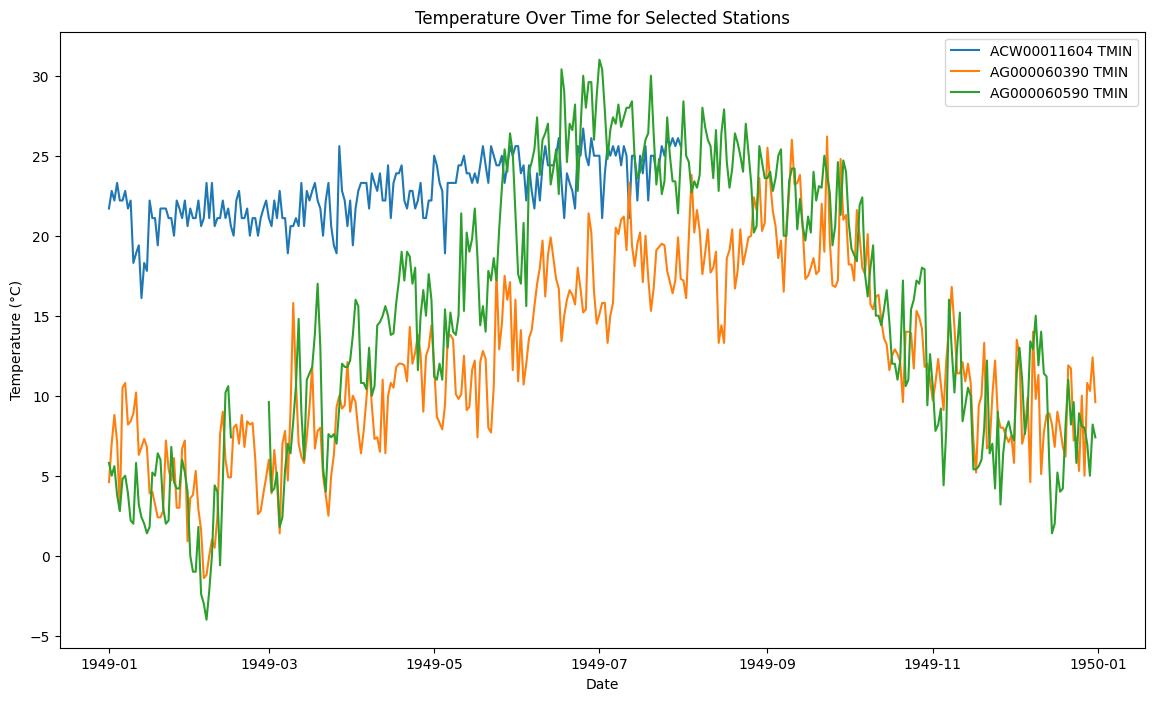

stationcode AG000060390 AG000060590
param              TMIN        TMIN
datelabel                          
1950-01-01          8.0         3.6
1950-01-02          7.4         5.4
1950-01-03          7.0         4.9
1950-01-04          6.8         2.0
1950-01-05          5.7         3.8
ACW00011604
MultiIndex([('AG000060390', 'TMIN'),
            ('AG000060590', 'TMIN')],
           names=['stationcode', 'param'])
AG000060390
MultiIndex([('AG000060390', 'TMIN'),
            ('AG000060590', 'TMIN')],
           names=['stationcode', 'param'])
Hi2
AG000060590
MultiIndex([('AG000060390', 'TMIN'),
            ('AG000060590', 'TMIN')],
           names=['stationcode', 'param'])
Hi2


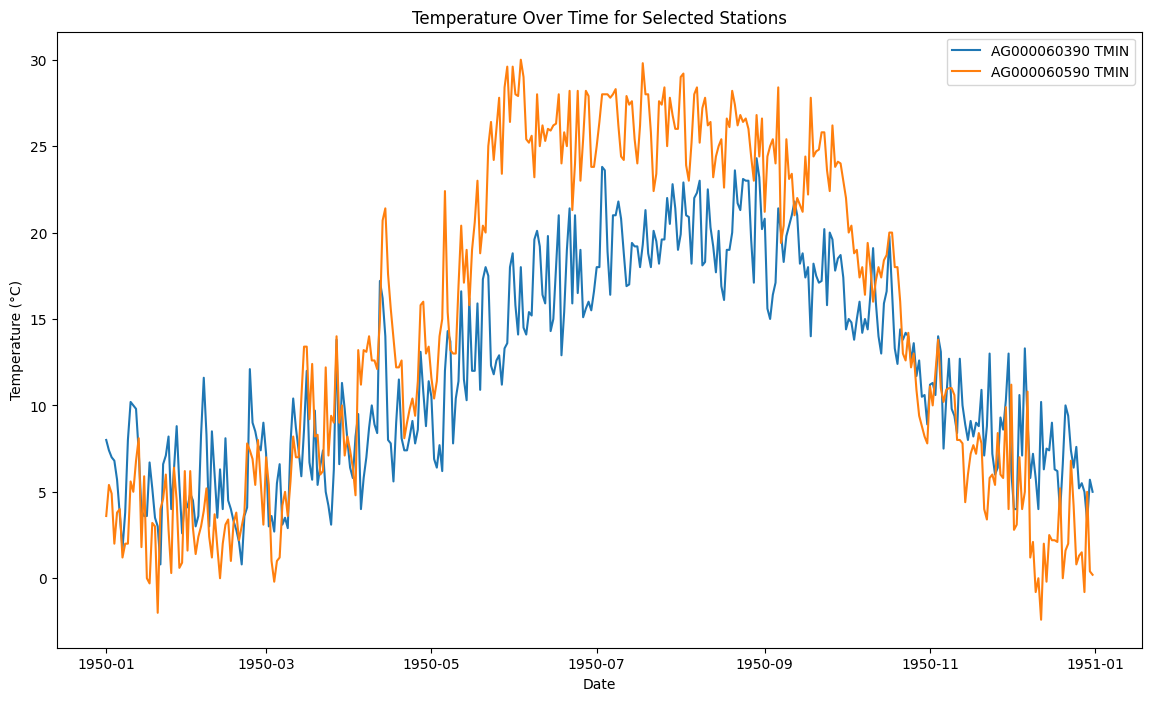

In [ ]:
for year in years: 
    df = pd.DataFrame(climate_data[year], columns=["id", "stationcode", "datelabel", "param", "value"])
    
    df['datelabel'] = pd.to_datetime(df['datelabel'], format='%Y%m%d')

    # Convert data_value to numeric
    df['value'] = pd.to_numeric(df['value'], errors='coerce')

    # Select a few stations for the plot
    stations_to_plot = ['ACW00011604', 'AG000060390', 'AG000060590']

    # Filter data for selected stations
    filtered_data = df[df['stationcode'].isin(stations_to_plot)]

    # Pivot data for easier plotting
    pivoted_data = filtered_data.pivot_table(index='datelabel', columns=['stationcode', 'param'], values='value')


    # Plotting
    plt.figure(figsize=(14, 8))
    for station in stations_to_plot:
        if (station, 'TMAX') in pivoted_data.columns:
            plt.plot(pivoted_data.index, pivoted_data[(station, 'TMAX')], label=f'{station} TMAX')
        if (station, 'TMIN') in pivoted_data.columns:
            plt.plot(pivoted_data.index, pivoted_data[(station, 'TMIN')], label=f'{station} TMIN')

    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.title('Temperature Over Time for Selected Stations')
    plt.legend()
    plt.show()

In [ ]:
# climate_data = get_table_data(years, ["id", "datelabel", "param", "value"], "param in ('TMXAX', 'TMIN')" )
# station_data = get_station_table_data(["id", "latitude", "longitude", "elevation", "name"])
print(climate_data[0])
# Convert date to datetime format
climate_data['datelabel'] = pd.to_datetime(climate_data['datelabel'], format='%Y%m%d')


# Convert data_value to numeric
climate_data['value'] = pd.to_numeric(climate_data['value'], errors='coerce')

# Select a few stations for the plot
stations_to_plot = ['ACW00011604', 'AG000060390', 'AG000060590']

# Filter data for selected stations
filtered_data = climate_data[climate_data['id'].isin(stations_to_plot)]

# Pivot data for easier plotting
pivoted_data = filtered_data.pivot_table(index='datelabel', columns=['id', 'param'], values='value')

# Plotting
plt.figure(figsize=(14, 8))
for station in stations_to_plot:
    if ('TMAX', station) in pivoted_data.columns:
        plt.plot(pivoted_data.index, pivoted_data[('TMAX', station)], label=f'{station} TMAX')
    if ('TMIN', station) in pivoted_data.columns:
        plt.plot(pivoted_data.index, pivoted_data[('TMIN', station)], label=f'{station} TMIN')

plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over Time for Selected Stations')
plt.legend()
plt.show()

KeyError: 0

## 2. Geographical Distribution of Stations

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(station_data['longitude'], station_data['latitude'], c=station_data['elevation'], cmap='viridis', marker='o')
plt.colorbar(label='Elevation (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Distribution of Stations')
plt.show()

## 3. Precip Levels 

In [ ]:
# Query to get precipitation data
prcp_query = """
SELECT id, date, data_value
FROM climate_data
WHERE element = 'PRCP'
"""

prcp_data = pd.read_sql(prcp_query, engine)
prcp_data['date'] = pd.to_datetime(prcp_data['date'], format='%Y%m%d')
prcp_data['data_value'] = pd.to_numeric(prcp_data['data_value'], errors='coerce')

# Aggregate precipitation by station and year
prcp_data['year'] = prcp_data['date'].dt.year
annual_prcp = prcp_data.groupby(['id', 'year'])['data_value'].sum().reset_index()

# Select a specific year for plotting
year_to_plot = 1949
annual_prcp_1949 = annual_prcp[annual_prcp['year'] == year_to_plot]

# Merge with station data to get station names
annual_prcp_1949 = annual_prcp_1949.merge(station_data[['id', 'name']], on='id')

# Plotting
plt.figure(figsize=(14, 8))
plt.bar(annual_prcp_1949['name'], annual_prcp_1949['data_value'])
plt.xlabel('Station')
plt.ylabel('Total Precipitation (mm)')
plt.title(f'Total Precipitation in {year_to_plot} Across Stations')
plt.xticks(rotation=90)
plt.show()


### Beispiel Tasks

1. Verlaufsplot über ein Jahr von mehreren Stations im Vergleich
2. Boxplot

<!-- select stationcode, value
WHERE year = Y AND month = X AND param IN (paramList) -->
3. Geographischen Plot

In [ ]:
def get_table_data_boxplot(parameter=None, year=None, month=None, stationcode=None):
    """
    Retrieves data from the SQL database.
        
    :param years: 
    :param columns: 
    :param condition: 

    :return: 
    """
    # connect to database
    connection, cursor = connect_to_db(dbname, dbuser, dbpassword, host, port)
    print("Connection established.")
    try:
        table_name = f'Climate{year}'

        columns = ["stationcode", "datelabel", "value"]
        condition = f"""
            date_part('year', datelabel) = {year} AND date_part('month', datelabel)= \'{month}\' AND stationcode = \'{stationcode}\' AND param=\'{parameter}\'
        """
        #
        # Construct the COUNT query using psycopg2.sql
        command = sql.SQL('''
                SELECT {columns} 
                FROM {table}
                WHERE {condition}
                                
                ''').format(
            columns=sql.SQL(', ').join(map(sql.Identifier, columns)),
            table=sql.Identifier(table_name),
            condition=sql.SQL(condition)
        )

        # print(command.as_string(cursor.connection))
        # Execute the SELECT query
        cursor.execute(command)
        result = cursor.fetchall()

        df = pd.DataFrame(result, columns=columns)

        print(f"Dataframe for boxplot has {len(df)} values")

        return df

    except Exception as error:
        print(f"Error: {error}")
        if connection:
            connection.rollback()

    finally:
        if cursor:
            cursor.close()
        if connection:
            connection.close()

In [ ]:
df_get = get_table_data_boxplot(parameter="TMIN", year=1950, month=7, stationcode="AG000060390")

df_get['datelabel'] = pd.to_datetime(df_get['datelabel'], format='%Y%m%d')

df_get.head()

Connected to database NCEIDatabase with user ESDP with password esdp1
Connection established.
Dataframe for boxplot has 31 values


,stationcode,datelabel,value
0,AG000060390,1950-07-26,19.6
1,AG000060390,1950-07-13,17.0
2,AG000060390,1950-07-16,19.2
3,AG000060390,1950-07-27,22.0
4,AG000060390,1950-07-28,20.5


Connected to database NCEIDatabase with user ESDP with password esdp1
Connection established.
Dataframe for boxplot has 31 values
Connected to database NCEIDatabase with user ESDP with password esdp1
Connection established.
Dataframe for boxplot has 31 values


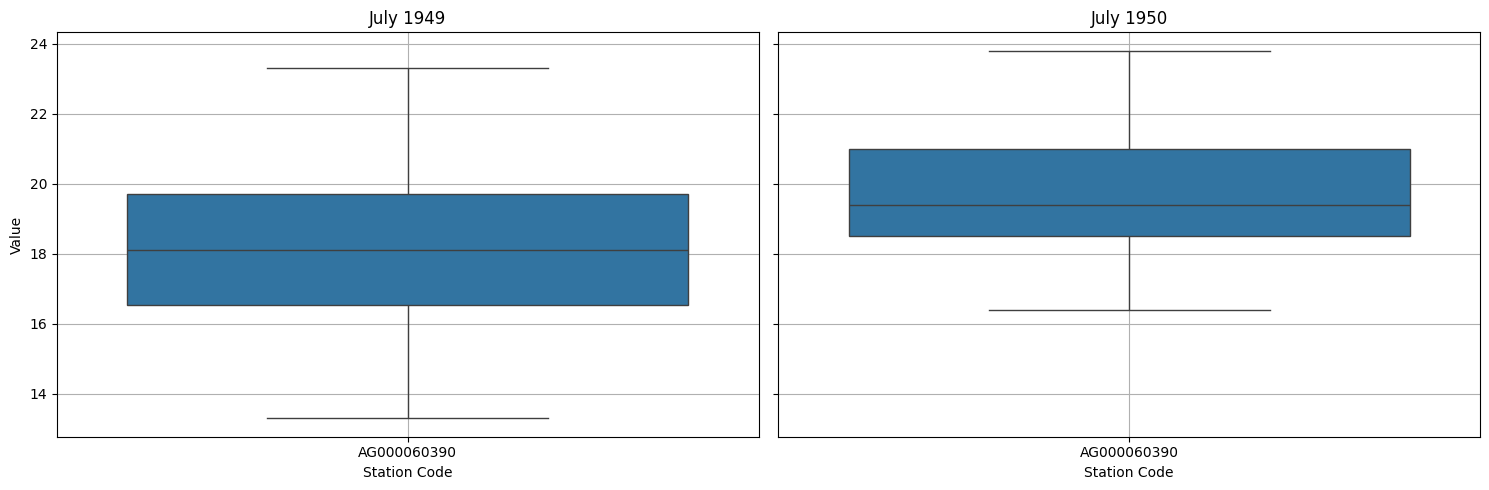

In [18]:
years_to_plot = [1949, 1950]

fig, axes = plt.subplots(1, len(years_to_plot), figsize=(15, 5), sharey=True)

if len(years_to_plot) == 1:
    axes = [axes]  # Ensure axes is iterable if there's only one subplot

for ax, year in zip(axes, years_to_plot):
    df_get = get_table_data_boxplot(parameter="TMIN", year=year, month=7, stationcode="AG000060390")

    df_get['datelabel'] = pd.to_datetime(df_get['datelabel'], format='%Y%m%d')
    df_get['year'] = df_get['datelabel'].dt.year

    # Filter data for the current year and month (July)
    year_data = df_get[(df_get['year'] == year) & (df_get['datelabel'].dt.month == 7)]
    
    # Create the boxplot
    sns.boxplot(x='stationcode', y='value', data=year_data, ax=ax)
    
    # Set plot labels and title
    ax.set_title(f'July {year}')
    ax.set_xlabel('Station Code')
    ax.set_ylabel('Value')
    ax.grid()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

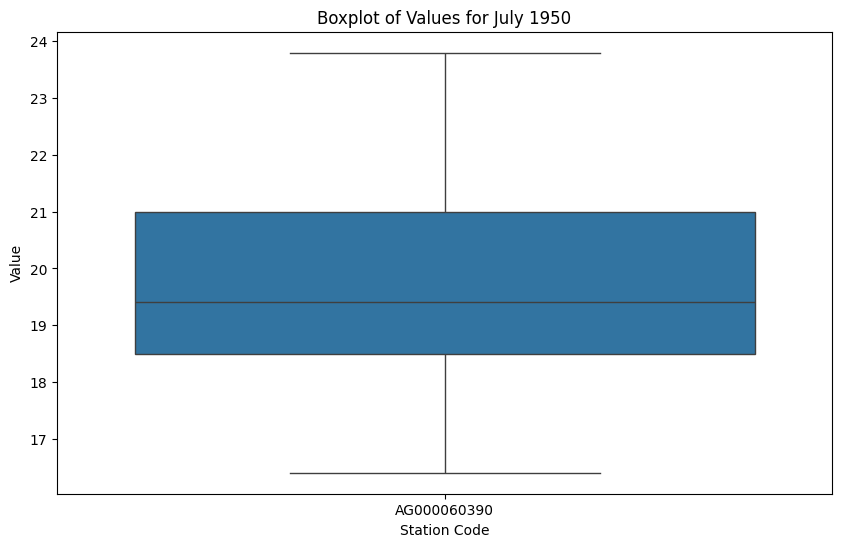